### Library

* cv2: computer vision library
* matplotlib: plotting library
* lib_detection: library which is used to load model and deliver prediction

In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from lib_detection import load_model, detect_lp, im2single

Using TensorFlow backend.
C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py

### Load mode

In [3]:
wpod_net_path = "wpod-net_update1.json"
wpod_net = load_model(wpod_net_path)

W0102 00:35:56.617464  9468 deprecation_wrapper.py:119] From C:\ProgramData\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:4070: The name tf.nn.max_pool is deprecated. Please use tf.nn.max_pool2d instead.



### Test an image

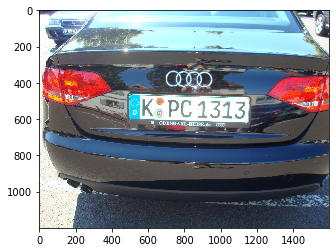

In [4]:
vehicle = plt.imread("test/detection_test.jpg")
plt.imshow(vehicle)

### LpImg variable returned from detect_lp() function is/are the cropped plate image(s= from our vehicle image

In [54]:
Dmax = 608
Dmin = 288

ratio = float(max(vehicle.shape[:2])) / min(vehicle.shape[:2])
side = int(ratio * Dmin)
bound_dim = min(side, Dmax)

L , LpImg, lp_type = detect_lp(wpod_net, im2single(vehicle), bound_dim, lp_threshold=0.5)

print("Detect %i plate(s)"%len(LpImg))

(24, 32, 8)
Detect 1 plate(s)


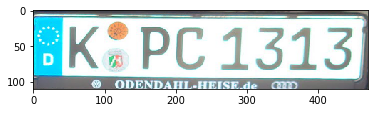

In [55]:
plt.imshow(LpImg[0])

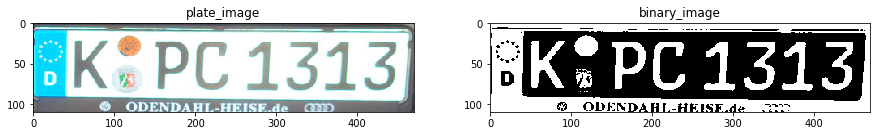

In [56]:
if (len(LpImg)):

    # Scales, calculates absolute values, and converts the result to 8-bit.
    plate_image = cv2.convertScaleAbs(LpImg[0], alpha=(255.0))

    roi = LpImg[0]

    # convert to grayscale
    gray = cv2.cvtColor(plate_image, cv2.COLOR_BGR2GRAY)


    # Applied inversed thresh_binary 
    binary = cv2.threshold(gray, 220, 255,
                         cv2.THRESH_BINARY_INV)[1]
    
    # plot images
    w,h = 15,5
    fig = plt.figure(figsize=(w,h))
    fig.add_subplot(1,2,1)
    plt.imshow(plate_image)
    plt.title('plate_image')
    
    fig.add_subplot(1,2,2)
    plt.imshow(binary,cmap='gray')
    plt.title('binary_image')
    
    


### Load svc model which is used to predict license digit

In [57]:
from sklearn.externals import joblib
digit_model = joblib.load("svc_digit_recognition.joblib")

In [58]:
### Create sort_contours() function to grab the contour of each digit

In [59]:
def sort_contours(cnts):

    reverse = False
    i = 0
    boundingBoxes = [cv2.boundingRect(c) for c in cnts]
    (cnts, boundingBoxes) = zip(*sorted(zip(cnts, boundingBoxes),
                                        key=lambda b: b[1][i], reverse=reverse))
    return cnts

W0102 01:11:19.685896  9468 image.py:700] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


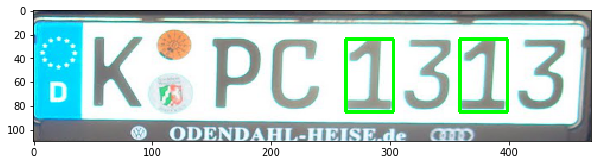

In [52]:
kernel3 = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
thre_mor = cv2.morphologyEx(binary, cv2.MORPH_DILATE, kernel3)
cont, _  = cv2.findContours(thre_mor, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)

digit_w = 30
digit_h = 60 

plate_info = ""

plt.figure(figsize=(10,5))

for c in sort_contours(cont):
    (x, y, w, h) = cv2.boundingRect(c)
    ratio = h/w
    if 1.5<=ratio<=3.5: # Chon cac contour dam bao ve ratio w/h
        if h/roi.shape[0]>=0.5: # Chon cac contour cao tu 60% bien so tro len

            # Ve khung chu nhat quanh so
            cv2.rectangle(roi, (x, y), (x + w, y + h), (0, 255, 0), 2)

            # Tach so va predict
            curr_num = thre_mor[y:y+h,x:x+w]
            curr_num = cv2.resize(curr_num, dsize=(digit_w, digit_h))
            _, curr_num = cv2.threshold(curr_num, 30, 255, cv2.THRESH_BINARY)
            #curr_num = np.array(curr_num,dtype=np.float32)
            #curr_num = curr_num.reshape(-1, digit_w * digit_h)

plt.imshow(roi)

In [17]:
kernel3 = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
thre_mor = cv2.morphologyEx(binary, cv2.MORPH_DILATE, kernel3)
cont, _  = cv2.findContours(thre_mor, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)

digit_w = 30
digit_h = 60 

plate_info = ""

for c in sort_contours(cont):
    (x, y, w, h) = cv2.boundingRect(c)
    ratio = h/w
    if 1.5<=ratio<=3.5: # Chon cac contour dam bao ve ratio w/h
        if h/roi.shape[0]>=0.5: # Chon cac contour cao tu 60% bien so tro len

            # Ve khung chu nhat quanh so
            cv2.rectangle(roi, (x, y), (x + w, y + h), (0, 255, 0), 2)

            # Tach so va predict
            curr_num = thre_mor[y:y+h,x:x+w]
            curr_num = cv2.resize(curr_num, dsize=(digit_w, digit_h))
            _, curr_num = cv2.threshold(curr_num, 30, 255, cv2.THRESH_BINARY)
            curr_num = np.array(curr_num,dtype=np.float32)
            curr_num = curr_num.reshape(-1, digit_w * digit_h)

            # Dua vao model SVM
            result = digit_model.predict(curr_num)[1]
            result = int(result[0, 0])

            if result<9: # Neu la so thi hien thi luon
                result = str(result)
            else: #Neu la chu thi chuyen bang ASCII
                result = chr(result)

            plate_info +=result

plt.imshow(roi)

IndexError: too many indices for array